In [169]:
# jupyter setup for reloading modules
# %load_ext autoreload
# %autoreload 2


In [170]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import sqlite3
from paths import PF_DB_PATH, DATA_DIR, AUS_PATH
from IPython.display import Markdown as md
from IPython.display import display
import os
from dataclasses import dataclass
import itertools

DEBUG = False
PRIMARY_COLOR = "#3891ff"
SECONDARY_COLOR = "#c7cee7"
MISC_COLOR= '#cfcfcf'
PALETTE_TWO_COLOR = [SECONDARY_COLOR, PRIMARY_COLOR]
PALETTE_THREE_COLOR = [PRIMARY_COLOR, "#91aef4", SECONDARY_COLOR]
PALETTE_SIX_COLOR = [
    PRIMARY_COLOR,
    "#669cfb",
    "#84a8f6",
    "#9db5f1",
    "#b3c1ec",
    SECONDARY_COLOR,
]


In [171]:
Chart.id_iter = itertools.count()  # reset itertool for each run


In [172]:
def dist(lat1, lon1, lat2, lon2):
    # calculate distance between two coordinates
    return np.sqrt((lat1 - lat2) ** 2 + (lon1 - lon2) ** 2) * 60 * 1.852


In [173]:
def display_list(lst: list, sep=", ") -> str:
    # join list items to return a merged str for display
    return sep.join(lst)


def million(price):
    # format price into million
    return f"{price/1e6:.1f}M"

def percent(rate):
    # format rate into percentage
    return f'{rate:.1%}'


def debug(df):
    # display df only in debug mode
    # - hide df printout when exporting html
    if DEBUG:
        display(df)


In [200]:
@dataclass
class Chart:
    """
    Object to hold matplotlib objects and chart label, id, caption
    """

    id_iter = itertools.count()  # iter tool for generating running id for each Chart
    title: str = ""  # title for this chart
    caption: str = ""  # caption for this chart
    label_txt: str = "Fig. "  # label of figure id for this chart
    nrow: int = 1  # number of rows in this chart
    ncol: int = 1  # number of columns in this chart
    figsize: tuple = None  # if not None, this will override scale
    # scale figsize accordig to nrow and ncol (so each chart is square in shape)
    figsize_scale: int = 5
    use_tight_layout: bool = False  # use fig.tight_layout or not
    ax = None  # current matplotlib ax object

    def __post_init__(self):
        self.id = next(Chart.id_iter) + 1  # 1-based id
        # create new matplotlit fig
        figsize = (
            self.figsize
            if self.figsize
            else (self.ncol * self.figsize_scale, self.nrow * self.figsize_scale)
        )
        self.fig, axs = plt.subplots(self.nrow, self.ncol, figsize=figsize)
        if isinstance(axs, np.ndarray):
            # make axs an iter object
            self.ax_iter = iter(axs.ravel())
        else:
            # single ax only, make it list first before turning into iter
            self.ax_iter = iter([axs])
        # --- fig config ---
        # set tight_layout
        if self.use_tight_layout:
            self.fig.tight_layout()
        # set main title
        if self.title:
            self.fig.suptitle(self.title, size=16)
            self.fig.subplots_adjust(top=0.85)
        # set figure caption
        if self.caption:
            # set caption
            self.fig.text(0.5, 0.0, self.full_caption, ha="center", size=12)

    @property
    def next_ax(self):
        self.ax = next(self.ax_iter)
        return self.ax

    @property
    def label(self):
        return f"{self.label_txt}{self.id}"

    @property
    def full_caption(self):
        if self.caption:
            return f"{self.label} {self.caption}"
        else:
            return ""

    def reset_id(self):
        Chart.id_iter = itertools.count() + 1

    def format(
        self,
        show_spines=False,
        show_xaxis=False,
        show_yaxis=False,
        xlabel=None,
        ylabel=None,
        title=None,
        x_use_million=False,
        x_use_percent=False,
        x_use_unit=None,
        x_use_int=False,
        y_use_million=False,
        y_use_percent=False,
        y_use_unit=None,
        y_use_int=False,
        ret_ax=False,
    ):
        if not self.ax:
            raise ValueError("ax not defined")
        ax = self.ax
        # declutter chart by removing unneccessary elements
        # remove spines from chart
        ax.spines["top"].set_visible(show_spines)
        ax.spines["right"].set_visible(show_spines)
        ax.spines["bottom"].set_visible(show_spines)
        ax.spines["left"].set_visible(show_spines)
        # remove x axis
        ax.xaxis.set_visible(show_xaxis)
        # handle x axis labels
        ax.set_xlabel(xlabel)
        # format axis
        if x_use_million:
            ax.xaxis.set_major_formatter(lambda x, pos: million(x))
        if x_use_percent:
            ax.xaxis.set_major_formatter(lambda x, pos: percent(x))
        if x_use_unit:
            ax.xaxis.set_major_formatter(lambda x, pos: f"{x:.0f} {x_use_unit}")
        if x_use_int:
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))

        # remove y axis
        ax.yaxis.set_visible(show_yaxis)
        # handle y axis label
        ax.set_ylabel(ylabel)
        # format axis
        if y_use_million:
            ax.yaxis.set_major_formatter(lambda x, pos: million(x))
        if y_use_percent:
            ax.yaxis.set_major_formatter(lambda x, pos: percent(x))
        if y_use_unit:
            ax.yaxis.set_major_formatter(lambda x, pos: f"{x:.0f} {y_use_unit}")
        if y_use_int:
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))

        # set chart title
        ax.set_title(title, loc="left")

        # declutter legend
        legend = ax.get_legend()
        if legend:
            legend.get_frame().set_linewidth(0)
            legend.set_title(None)

        if ret_ax:
            return ax


# Introduction

This exploratory analysis was done as an overview of property price trend in Sydney, which would help my family (as new immigrants) to plan our potential future purchase. 

First few sections serve as a general understanding of how the overall market behaves over the year, while in the later part of this analysis, focus was gradually shifted towards properties that best suit our needs.

# Dataset
Data source: https://www.pricefinder.com.au/

This dataset was downloaded from PriceFinder as separated `.xlsx` files, which were then merged into a single SQLite database. The SQL database consists of 2 tables:

In [175]:
con = sqlite3.connect(PF_DB_PATH)
raw_records = pd.read_sql_query("SELECT * FROM record", con)
raw_property = pd.read_sql_query("SELECT * FROM property", con)


In [176]:
md(
    f"""
1. records\n
    This table contains {raw_records.shape[0]:,} property sales records, each record contains the following data:
    * `id`: unique identification of the sales record, formed by merging address, postcode and sale date
    * `record_date`: date of sale (from {raw_records.record_date.min()} to {raw_records.record_date.max()})
    * `price`: final sale price
    * `sale_type`: type of sale ({display_list(raw_records.sale_type.unique().tolist())})
    * `prop_id`: id of the property, formed by merging address and postcode
    * `property_type`: type of property ({display_list(raw_records.property_type.unique().tolist())})
    * `bedrooms`: number of bedrooms
    * `bathrooms`: number of bathrooms
    * `carparks`: number of car parks
2. property\n
    This table contains {raw_property.shape[0]:,} properties that have associated sales record(s), each property details consist of the following data:
    * `address`: address with postcode attached, act as unique identification
    * `street`: street name
    * `locality`: suburb name ({raw_property.locality.nunique()} in total)
    * `postcode`: postcode ({raw_property.postcode.nunique()} in total)
    * `land_area`: land area
"""
)



1. records

    This table contains 731,552 property sales records, each record contains the following data:
    * `id`: unique identification of the sales record, formed by merging address, postcode and sale date
    * `record_date`: date of sale (from 2000-01-05 to 2022-01-04)
    * `price`: final sale price
    * `sale_type`: type of sale (Agents Advice - Sale, Normal Sale, Multi-Sale, Part Sale, Unknown)
    * `prop_id`: id of the property, formed by merging address and postcode
    * `property_type`: type of property (Commercial, Unit, Other, House, Vacant Land, Industrial)
    * `bedrooms`: number of bedrooms
    * `bathrooms`: number of bathrooms
    * `carparks`: number of car parks
2. property

    This table contains 455,865 properties that have associated sales record(s), each property details consist of the following data:
    * `address`: address with postcode attached, act as unique identification
    * `street`: street name
    * `locality`: suburb name (844 in total)
    * `postcode`: postcode (312 in total)
    * `land_area`: land area


In [177]:
debug(raw_records.describe(include="all"))
debug(raw_property.describe(include="all"))


# Data Cleaning

In [178]:
# raw dataframe
df_raw = pd.merge(
    raw_records, raw_property, left_on="prop_id", right_on="address", how="left"
).drop(columns=["prop_id"])

# filtered dataframe
last_record_date = "2021-12-31"
df_clean = df_raw.query(
    f"0<=bedrooms<=5 & 0<bathrooms<=5 & 0<=carparks <=3 & price >1000"
)
df_clean = df_clean[df_clean.record_date <= last_record_date]
df_clean["year"] = pd.DatetimeIndex(df_clean.record_date).year


In [179]:
md(
    f"""
There is no missing values in both tables. For `records`, unusually high number of bedrooms, bathrooms and car parks were found, possibly due to the sales of buildings as a whole. Hence, for normal households, only properties with maximum 5 bedrooms/bathrooms and 3 car parks were considered.

On the other hand, it was noticed that some records show abnormally low prices. These records (specifically, all records with price less than $1,000) were removed from the analysis.

Also, to aid yearly aggregation, a `year` column was generated from `record_date`. It should be noted that only sales records on or before {last_record_date} were considered to ensure accuracy of annual statistics.

Consequently, a combined dataset was then formed by merging the two tables with left join on `records`. The final dataset for analysis consists of {df_clean.shape[0]:,} records ({df_clean.shape[0]/df_raw.shape[0]:.0%} of available records).

"""
)



There is no missing values in both tables. For `records`, unusually high number of bedrooms, bathrooms and car parks were found, possibly due to the sales of buildings as a whole. Hence, for normal households, only properties with maximum 5 bedrooms/bathrooms and 3 car parks were considered.

On the other hand, it was noticed that some records show abnormally low prices. These records (specifically, all records with price less than $1,000) were removed from the analysis.

Also, to aid yearly aggregation, a `year` column was generated from `record_date`. It should be noted that only sales records on or before 2021-12-31 were considered to ensure accuracy of annual statistics.

Consequently, a combined dataset was then formed by merging the two tables with left join on `records`. The final dataset for analysis consists of 641,588 records (88% of available records).



In [180]:
debug(raw_records.isna().sum())
debug(raw_property.isna().sum())
debug(df_clean.describe(include="all").style.format(dict(price="{:,.0f}")))


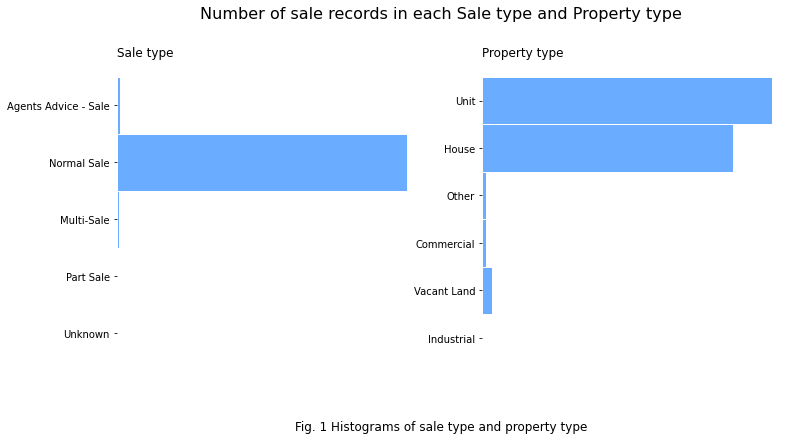

In [181]:
chart_sale_prop_type_hist = Chart(
    title="Number of sale records in each Sale type and Property type",
    nrow=1,
    ncol=2,
    caption="Histograms of sale type and property type",
    figsize_scale=6,
)

# sale type
ax = chart_sale_prop_type_hist.next_ax
sns.histplot(
    data=df_clean, y="sale_type", ax=ax, color=PRIMARY_COLOR, edgecolor="white"
)
chart_sale_prop_type_hist.format(show_yaxis=True, title="Sale type")

# property type
ax = chart_sale_prop_type_hist.next_ax
sns.histplot(
    data=df_clean, y="property_type", ax=ax, color=PRIMARY_COLOR, edgecolor="white"
)
chart_sale_prop_type_hist.format(show_yaxis=True, title="Property type")


In [182]:
md(
    f"""
Further analysis ({chart_sale_prop_type_hist.label}) suggested that most records were `Normal Sales` of either `House` or `Unit` properties. For simplicity and sake of interest, only these records were considered.
"""
)



Further analysis (Fig. 1) suggested that most records were `Normal Sales` of either `House` or `Unit` properties. For simplicity and sake of interest, only these records were considered.


In [183]:
# filter out selected sale_type and property_type
df_sel = df_clean[
    (df_clean.sale_type == "Normal Sale")
    & (df_clean.property_type.isin(["Unit", "House"]))
]

df = df_sel.query("price <= 3e6")


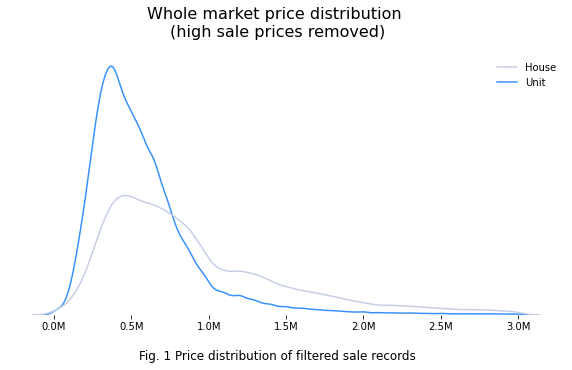

In [198]:
chart_all_price_dist = Chart(
    title="Whole market price distribution \n(high sale prices removed)",
    caption="Price distribution of filtered sale records",
    figsize=(10, 5),
)

sns.kdeplot(
    data=df.sort_values("property_type"),
    x="price",
    hue="property_type",
    ax=chart_all_price_dist.next_ax,
    palette=PALETTE_TWO_COLOR,
)
chart_all_price_dist.format(show_xaxis=True, x_use_million=True)


In [185]:
md(
    f"""
For sale prices, a small portion of properties were sold in high values. To focus on properties in reasonable range, only records with sale price below \$3,000,000 were considered. The sale price distribution after filtering is shown in {chart_all_price_dist.label} above.
"""
)



For sale prices, a small portion of properties were sold in high values. To focus on properties in reasonable range, only records with sale price below \$3,000,000 were considered. The sale price distribution after filtering is shown in Fig. 2 above.


In [186]:
debug(df.sale_type.unique())
debug(df.property_type.unique())


In [187]:
# export as csv
df.to_csv(os.path.join(DATA_DIR, "dataset.csv"), index=False)


In summary, the following criterias were applied:

- sales record date: on or before 2021-12-31
- number of bedrooms: 0 to 5
- number of bathrooms: 1 to 5
- number of car parks: 0 to 3
- sale price: \$1,000 to \$3,000,000

In [188]:
md(
    f"""
The final dataset therefore contains {df.shape[0]:,} records ({df.shape[0]/df_raw.shape[0]:.0%} of the raw data).
"""
)



The final dataset therefore contains 600,451 records (82% of the raw data).


# Analysis

### General price trend

In [189]:
def get_median(df):
    # median by property type and year
    df_med = (
        df.drop(columns=["postcode"])
        .groupby(["property_type", "year"])
        .median()
        .reset_index()
    )
    # add rate of change column
    df_med["price_change"] = (
        df_med.groupby(["property_type"]).price.diff() / df_med.price
    )
    df_med.year = df_med.year.astype(int)
    return df_med


df_med = get_median(df)
debug(df_med.head())


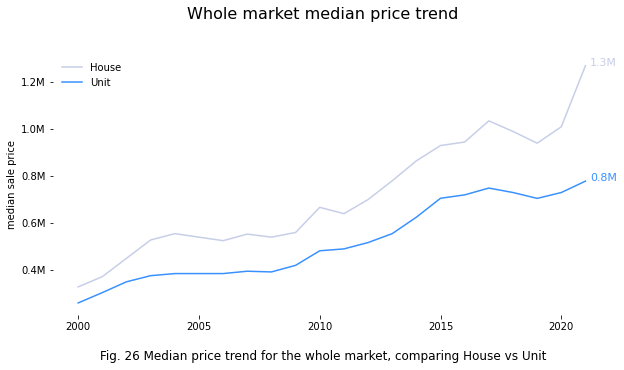

In [232]:
chart_all_med_price_trend = Chart(
    title="Whole market median price trend",
    caption="Median price trend for the whole market, comparing House vs Unit",
    figsize=(10, 5),
)
sns.lineplot(
    data=df_med,
    x="year",
    y="price",
    hue="property_type",
    ax=chart_all_med_price_trend.next_ax,
    palette=PALETTE_TWO_COLOR,
)
# annotate 2021 median price
house_y = df_med.set_index(["property_type", "year"]).loc[("House", 2021)].price
x_offset=0.2
chart_all_med_price_trend.ax.text(
    x=2021+x_offset, y=house_y, s=million(house_y), size=11, color=SECONDARY_COLOR
)
unit_y = df_med.set_index(["property_type", "year"]).loc[("Unit", 2021)].price
chart_all_med_price_trend.ax.text(
    x=2021+x_offset, y=unit_y, s=million(unit_y), size=11, color=PRIMARY_COLOR
)
# chart formatting
chart_all_med_price_trend.format(
    show_xaxis=True, show_yaxis=True, y_use_million=True, ylabel="median sale price"
)


In [191]:
md(f"""
General property price ({chart_all_med_price_trend.label}) is trending upwards, median prices for House and Unit in 2021 were {million(house_y)} and {million(unit_y)} respectively.
""")



General property price (Fig. 3) is trending upwards, median prices for House and Unit in 2021 were 1.3M and 0.8M respectively.


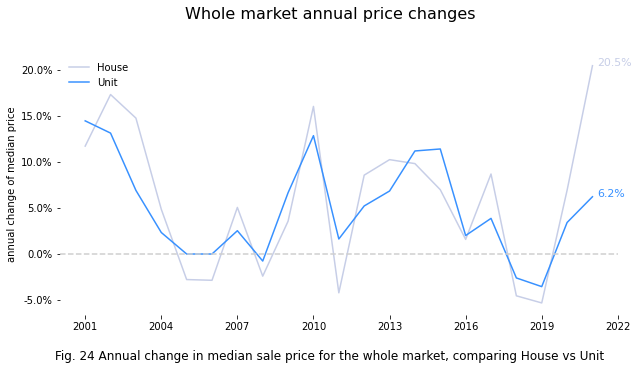

In [229]:
chart_all_med_rate_trend = Chart(
    title="Whole market annual price changes",
    caption="Annual change in median sale price for the whole market, comparing House vs Unit",
    figsize=(10, 5),
)
#-- price rate trend
sns.lineplot(
    data=df_med,
    x="year",
    y="price_change",
    hue="property_type",
    ax=chart_all_med_rate_trend.next_ax,
    palette=PALETTE_TWO_COLOR,
)
# annotate 2021 median price
x_offset= 0.2
house_y = df_med.set_index(["property_type", "year"]).loc[("House", 2021)].price_change
chart_all_med_rate_trend.ax.text(
    x=2021 + x_offset, y=house_y, s=percent(house_y), size=11, color=SECONDARY_COLOR
)
unit_y = df_med.set_index(["property_type", "year"]).loc[("Unit", 2021)].price_change
chart_all_med_rate_trend.ax.text(
    x=2021 + x_offset, y=unit_y, s=percent(unit_y), size=11, color=PRIMARY_COLOR
)
# chart formatting
chart_all_med_rate_trend.format(
    show_xaxis=True,
    show_yaxis=True,
    y_use_percent=True,
    x_use_int=True,
    ylabel="annual change of median price",
)
ax= chart_all_med_rate_trend.ax
ax.axhline(0, color= MISC_COLOR, linestyle='--')

In [193]:
md(f'''
As shown in {chart_all_med_rate_trend.label}, from 2000 to 2021 (21 years), positive growths in median price for House and Unit were observed in {df_med.query('price_change>0 & property_type=="House"').shape[0]} and {df_med.query('price_change>0 & property_type=="Unit"').shape[0]} of the recorded years respectively. Meaning property price in general has been growing consistently.
''')


As shown in Fig. 4, from 2000 to 2021 (21 years), positive growths in median price for House and Unit were observed in 15 and 16 of the recorded years respectively. Meaning property price in general has been growing consistently.


### Price trend by suburbs

In [194]:
# suburb coordinates
suburb_coord = pd.read_csv(os.path.join(AUS_PATH, "nsw_suburb_coord.csv"))
# calculate distance from CBD
CBD_COORD = (-33.8708, 151.2073)
suburb_coord["cbd_dist"] = suburb_coord.apply(
    lambda row: dist(row["lat"], row["lon"], CBD_COORD[0], CBD_COORD[1]), axis=1
)

# data grouped by suburb
df_sub = (
    df.groupby(["locality", "postcode", "property_type", "year"]).median().reset_index()
)
# merge to get coordinates
df_sub = df_sub.merge(suburb_coord, on="locality")
debug(suburb_coord.head())
debug(df_sub.head())


In [202]:
year = 2021

In [203]:
md(f'''
To see how sale prices are affected by localities, median prices in {year} of different suburbs were plotted agains their distance from Sydney CBD:
''')


To see how sale prices are affected by localities, median prices in 2021 of different suburbs were plotted agains their distance from Sydney CBD:


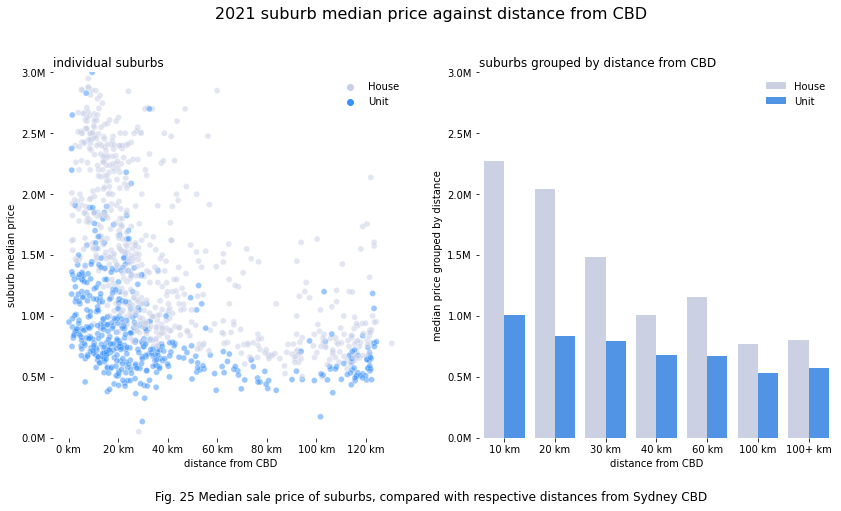

In [231]:
max_dist = 150
chart_price_to_cbd_dist = Chart(
    title=f"{year} suburb median price against distance from CBD",
    caption=f'Median sale price of suburbs, compared with respective distances from Sydney CBD',
    ncol=2,
    figsize_scale= 7
)
#-- scatter
sns.scatterplot(
    data=df_sub.query(f"year=={year} & cbd_dist<={max_dist}"),
    x="cbd_dist",
    y="price",
    hue="property_type",
    alpha=0.5,
    ax=chart_price_to_cbd_dist.next_ax,
    palette=PALETTE_TWO_COLOR,
)
chart_price_to_cbd_dist.ax.set_ylim(0,3e6)
chart_price_to_cbd_dist.format(
    show_xaxis=True,
    show_yaxis=True,
    y_use_million=True,
    ylabel='suburb median price',
    xlabel='distance from CBD',
    x_use_unit='km',
    title='individual suburbs'
)

#-- bar
bin_edges = [0, 10, 20, 30, 40, 60, 100]
labels = [f"{ed} km" for ed in bin_edges[1:]] + [f"{bin_edges[-1]}+ km"]
df_sub["dist_bin"] = pd.cut(df_sub.cbd_dist, bins=bin_edges + [np.inf], labels=labels)
sns.barplot(
    data=df_sub.query(f"year=={year}")
    .groupby(["property_type", "dist_bin"])
    .median()
    .reset_index(),
    x="dist_bin",
    y="price",
    ax=chart_price_to_cbd_dist.next_ax,
    hue="property_type",
    palette=PALETTE_TWO_COLOR,
)
chart_price_to_cbd_dist.ax.set_ylim(0,3e6)
chart_price_to_cbd_dist.format(
    show_yaxis=True,
    show_xaxis=True,
    y_use_million=True,
    xlabel='distance from CBD',
    ylabel='median price grouped by distance',
    title='suburbs grouped by distance from CBD'
)


In [218]:
md(f'''
{chart_price_to_cbd_dist.label} shows that, in 2021, property prices in suburbs closer to CBD are generally higher. The median prices begin to drop off passed 40 km (about 1 hour drive).

It was noticed that sale prices for Houses were significantly higher than Units within 30 km from Sydney CBD. Whereas prices for Units appeared to be far less affected by the distance.
''')


Fig. 13 shows that, in 2021, property prices in suburbs closer to CBD are generally higher. The median prices begin to drop off passed 40 km (about 1 hour drive).

It was noticed that sale prices for Houses were significantly higher than Units within 30 km from Sydney CBD. Whereas prices for Units appeared to be far less affected by the distance.


In [ ]:
CBD_RANGE = 35

md(
    f"""
### Suburbs closed to CBD
In this section, property sales within {CBD_RANGE} km of Sydney CBD were further analyzed.
"""
)



### Suburbs closed to CBD
In this section, property sales within 35 km of Sydney CBD were further analyzed.


In [ ]:
# list of suburbs within 40km of CBD
cbd_subs = suburb_coord.query(f"cbd_dist<={CBD_RANGE}").locality.tolist()
# data of sales closed to CBD
df_cbd = df[df.locality.isin(cbd_subs)]
# median by property type and year
df_cbd_med = get_median(df_cbd)
debug(df_cbd_med.head())
debug(df_cbd.locality.nunique())


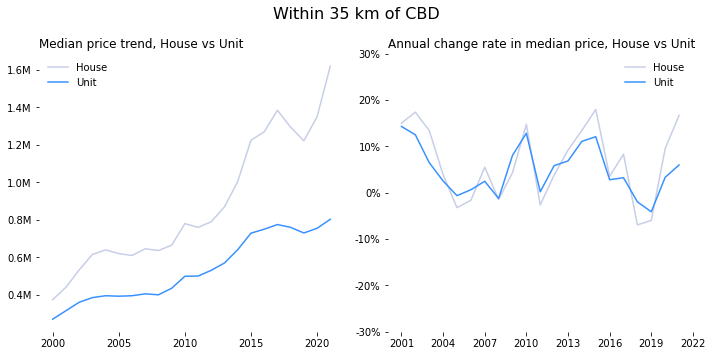

In [ ]:
_ = plot_annual_trend(df_cbd_med, title=f"Within {CBD_RANGE} km of CBD")


In [ ]:
md(
    f"""
Property price for CBD suburb trends upwards similar to the general market, with median annual increment rate (since 2000) being {df_cbd_med.query('property_type =="House"').price_change.median():.1%} for Houses and {df_cbd_med.query('property_type =="Unit"').price_change.median():.1%} for Units.
"""
)



Property price for CBD suburb trends upwards similar to the general market, with median annual increment rate (since 2000) being 5.5% for Houses and 3.3% for Units.


#### Annual rate regression
To gauge the price increments on each CBD suburbs, linear regression model was fitted on data of each locality. Assuming that the annual rate of change of price is constant, the price model is therefore:

$$log(price) = x_1  year + x_0$$

Note that only suburbs with properties sales in at least 9 years from 2000 to 2021 were considered.

In [ ]:
# remove localities with too few sale records by year
active_locs = df_cbd.groupby("locality").nunique().query("year >=9").index.tolist()


In [ ]:
N_YEAR_THRESHOLD = 9

md(
    f"""
In total, {len(active_locs)} out of {df_cbd.locality.nunique()} CBD suburbs matches this criteria. Note that among these suburbs, in order to obtain sensible results, regression models were fitted only if there are more than {N_YEAR_THRESHOLD} years with sales for each property type (House or Unit). 
"""
)



In total, 410 out of 436 CBD suburbs matches this criteria. Note that among these suburbs, in order to obtain sensible results, regression models were fitted only if there are more than 9 years with sales for each property type (House or Unit). 


In [ ]:
def log_regress(df, n_year_threshold=N_YEAR_THRESHOLD):
    # if number of years wtih sales is fewer than threshold, skip regression
    if df.year.nunique() < n_year_threshold:
        return None
    # model: log(price) ~ year
    model = LinearRegression()
    model.fit(X=np.array(df.year).reshape(-1, 1), y=np.log(df.price))
    results = pd.Series(
        (model.coef_[0], model.intercept_), index=["slope", "intercept"]
    )
    return results


results = (
    df_cbd[df_cbd.locality.isin(active_locs)]
    .groupby(["locality", "property_type"])
    .apply(log_regress)
)
results["annual_rate"] = np.exp(results.slope) - 1
debug(results.head())


In [ ]:
df_cbd_rates = results.reset_index()
debug(df_cbd_rates)


In [ ]:
df_cbd_sub = (
    df_cbd.groupby(["locality", "postcode", "property_type", "year"])
    .median()
    .reset_index()
)
debug(df_cbd_sub)


In [ ]:
def fit_price(years, coeffs):
    # return fitted values for given years
    prices = np.exp(years * coeffs["slope"].values + coeffs["intercept"].values)
    df = pd.DataFrame(dict(year=years, price=prices))
    return df


def get_loc_fitted_price(df, coeffs, loc):
    # return df containing fitted price for houses and units of given locality
    prices_house = fit_price(
        df.query("property_type=='House'").year,
        coeffs.query(f"locality=='{loc}' & property_type=='House'"),
    )
    prices_unit = fit_price(
        df.query("property_type=='Unit'").year,
        coeffs.query(f"locality=='{loc}' & property_type=='Unit'"),
    )

    prices = pd.concat(
        [
            pd.DataFrame(
                dict(
                    property_type="House",
                    year=prices_house.year,
                    price=prices_house.price,
                )
            ),
            pd.DataFrame(
                dict(
                    property_type="Unit", year=prices_unit.year, price=prices_unit.price
                )
            ),
        ],
        axis=0,
    )
    return prices


def plot_loc_trend(df_plot, coeffs, ax, loc):
    sns.scatterplot(
        data=df_plot,
        x="year",
        y="price",
        hue="property_type",
        ax=ax,
        palette=PALETTE_TWO_COLOR,
    )
    fitted_prices = get_loc_fitted_price(df_plot, coeffs, loc)
    sns.lineplot(
        data=fitted_prices,
        x="year",
        y="price",
        hue="property_type",
        palette=PALETTE_TWO_COLOR,
        ax=ax,
        linestyle="--",
        legend=False,
    )
    ax.legend(loc="upper left")

    # add label for annual rate
    fp = fitted_prices.set_index(["property_type", "year"])
    cf = coeffs.set_index(["property_type", "locality"])

    lab_x = df_plot.query('property_type=="House"').year.max()
    if ("House", loc) in cf.index and ("House", lab_x) in fp.index:
        lab_y = fp.at[("House", lab_x), "price"]
        rate = cf.at[("House", loc), "annual_rate"]
        if not np.isnan(lab_y) and not np.isnan(rate):
            ax.text(
                lab_x + 0.5,
                lab_y,
                s=f"{rate:.1%}",
                ha="left",
                va="center",
                color=PALETTE_TWO_COLOR[0],
            )

    lab_x = df_plot.query('property_type=="Unit"').year.max()
    if ("Unit", loc) in cf.index and ("Unit", lab_x) in fp.index:
        lab_y = fp.at[("Unit", lab_x), "price"]
        rate = cf.at[("Unit", loc), "annual_rate"]
        if not np.isnan(lab_y) and not np.isnan(rate):
            ax.text(
                lab_x + 0.5,
                lab_y,
                s=f"{rate:.1%}",
                ha="left",
                va="center",
                color=PALETTE_TWO_COLOR[1],
            )

    # limit axis for comparison
    ax.set_ylim(0, 3e6)
    ax.set_xlim(2000, 2022)
    decluter(
        ax,
        show_xaxis=True,
        show_yaxis=True,
        y_use_million=True,
        x_use_int=True,
        title=f"{loc.title()}",
    )


### Suburbs with highest growth rate

With regression applied, suburbs with highest growth rates in both Houses and Units were plotted below as references.

In [ ]:
house_rate = df_cbd_rates.query('property_type=="House"').annual_rate
unit_rate = df_cbd_rates.query('property_type=="Unit"').annual_rate

md(
    f"""
In general, growth rate for both Houses and Units are normally distributed. Houses generally see higher growth rate with mean of {house_rate.mean():.1%} and standard deviation of {house_rate.std():.1%}, while that for Units are mean of {unit_rate.mean():.1%} and s.d. of {unit_rate.std():.1%}.
"""
)



In general, growth rate for both Houses and Units are normally distributed. Houses generally see higher growth rate with mean of 6.4% and standard deviation of 1.8%, while that for Units are mean of 5.1% and s.d. of 1.2%.


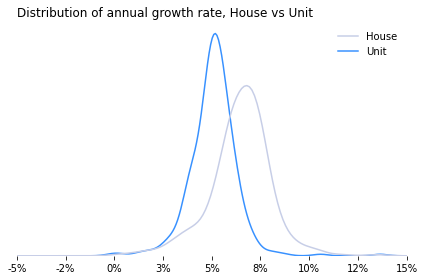

In [ ]:
fig, ax = plt.subplots()
sns.kdeplot(
    data=df_cbd_rates,
    hue="property_type",
    x="annual_rate",
    ax=ax,
    palette=PALETTE_TWO_COLOR,
)
ax.set_xlim(-0.05, 0.15)
ax.xaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")
decluter(ax, show_xaxis=True, title="Distribution of annual growth rate, House vs Unit")
fig.tight_layout()


#### House

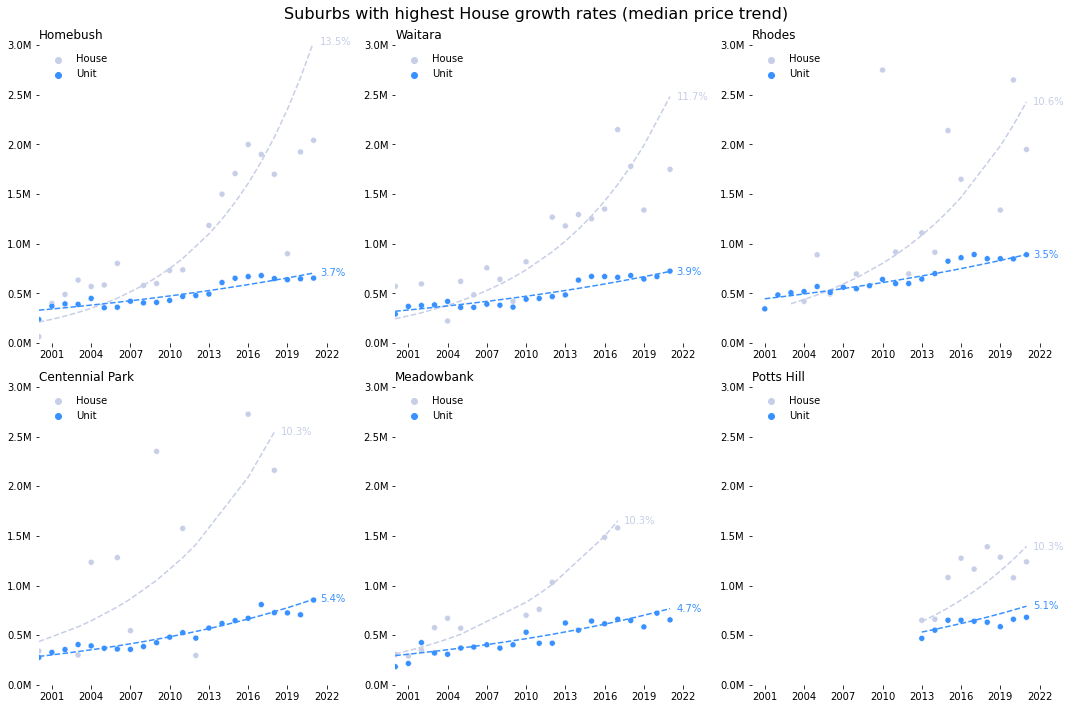

In [ ]:
# localities with top House annual rate
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = iter(axs.ravel())

top_house_locs = (
    df_cbd_rates.query('property_type=="House"')
    .sort_values("annual_rate", ascending=False)
    .head(6)
    .locality
)

for loc in top_house_locs:
    ax = next(axs)
    df_plot = df_cbd_sub.query(f"locality=='{loc}'")
    plot_loc_trend(df_plot, df_cbd_rates, ax, loc)

fig.suptitle("Suburbs with highest House growth rates (median price trend)", size=16)
fig.subplots_adjust(top=0.92)
fig.tight_layout()


#### Unit

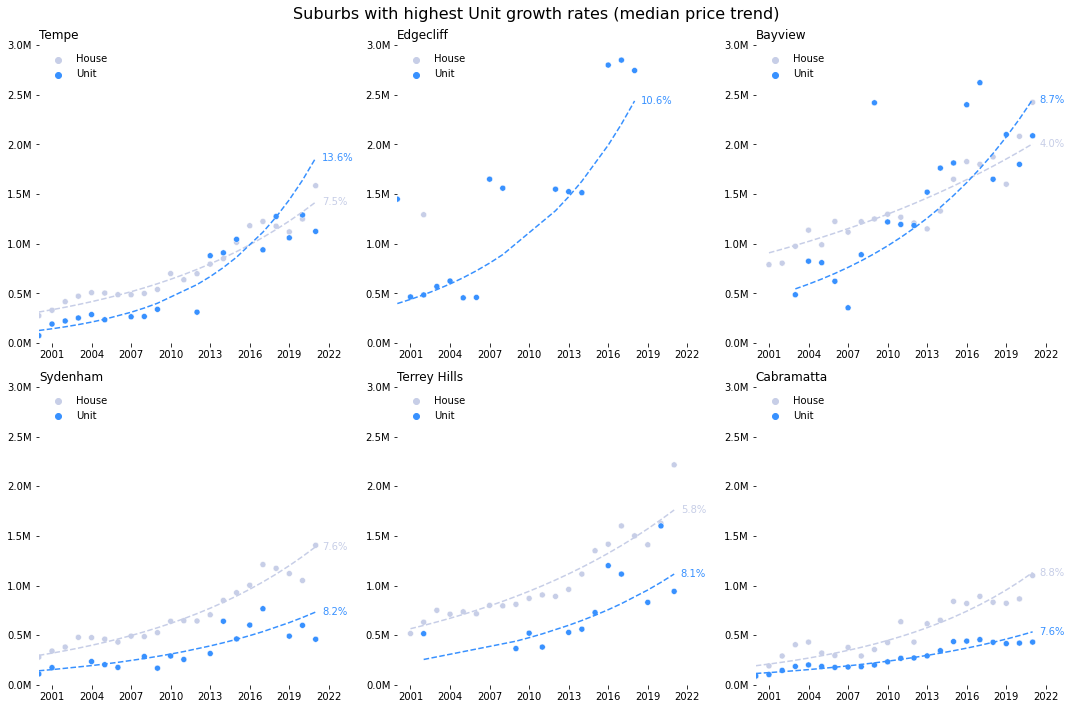

In [ ]:
# localities with top Unit annual rate
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = iter(axs.ravel())

top_unit_locs = (
    df_cbd_rates.query('property_type=="Unit"')
    .sort_values("annual_rate", ascending=False)
    .head(6)
    .locality
)

for loc in top_unit_locs:
    ax = next(axs)
    df_plot = df_cbd_sub.query(f"locality=='{loc}'")
    plot_loc_trend(df_plot, df_cbd_rates, ax, loc)

fig.suptitle("Suburbs with highest Unit growth rates (median price trend)", size=16)
fig.subplots_adjust(top=0.92)
fig.tight_layout()


### Unit properties, number of bedrooms

In this section, property prices of Units with different number of bedrooms were analyzed. Note that only CBD suburbs were considered.

In [ ]:
df_unit = df_cbd.query('property_type =="Unit"')
df_unit_med = df_unit.groupby(["bedrooms", "year"]).median().reset_index()


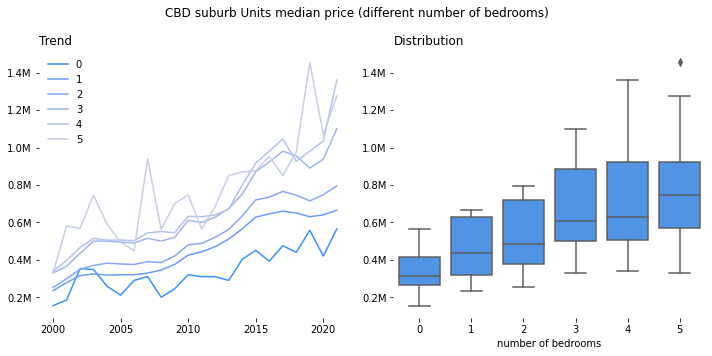

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = iter(axs.ravel())

ax = next(axs)
sns.lineplot(
    data=df_unit_med,
    x="year",
    y="price",
    hue="bedrooms",
    ax=ax,
    palette=PALETTE_SIX_COLOR,
)
decluter(
    ax,
    show_xaxis=True,
    show_yaxis=True,
    y_use_million=True,
    title="Trend",
)

ax = next(axs)
sns.boxplot(data=df_unit_med, x="bedrooms", y="price", ax=ax, color=PRIMARY_COLOR)
decluter(
    ax,
    show_xaxis=True,
    show_yaxis=True,
    y_use_million=True,
    xlabel="number of bedrooms",
    title="Distribution",
)

fig.suptitle("CBD suburb Units median price (different number of bedrooms)")
fig.tight_layout()


In general, more bedrooms imply higher median price.

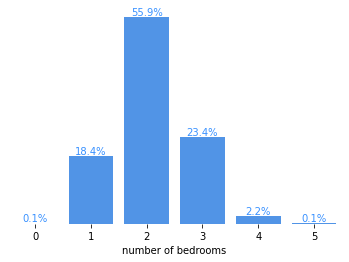

In [ ]:
fig, ax = plt.subplots()
sns.countplot(data=df_unit, x="bedrooms", color=PRIMARY_COLOR, ax=ax)
for bedrooms in range(6):
    count = df_unit.query(f"bedrooms == {bedrooms}").shape[0]
    ax.text(
        x=bedrooms,
        y=count,
        s=f"{count/df_unit.shape[0]:.1%}",
        ha="center",
        va="bottom",
        color=PRIMARY_COLOR,
    )
decluter(ax, show_xaxis=True, x_use_int=True, xlabel="number of bedrooms")


In [ ]:
md(
    f"""
As revealed in this bar chart, majority of the Units sold were 2-bedrooms, with Units of 1-3 bedrooms constitude  {df_unit.query('1<=bedrooms<=3').shape[0]/df_unit.shape[0]:.1%} of all the properties..
"""
)



As revealed in this bar chart, majority of the Units sold were 2-bedrooms, with Units of 1-3 bedrooms constitude  97.6% of all the properties..


In [ ]:
df_unit_sel = df_unit.query("1<= bedrooms <=3")

results = df_unit_sel.groupby(["locality", "bedrooms"]).apply(log_regress)
results["annual_rate"] = np.exp(results.slope) - 1
df_unit_rates = results.reset_index()


In [ ]:
def plot_loc_trend_bed(df, rates, ax, loc):
    df_plot = df.query(f'locality=="{loc}"')
    years = df_plot.year.unique()
    bedrooms = [1, 2, 3]
    fitted_price = pd.DataFrame()
    rt = rates.set_index(["locality", "bedrooms"])
    for bed in bedrooms:
        if (loc, bed) in rt.index:
            slope = rt.loc[(loc, bed), "slope"]
            inter = rt.loc[(loc, bed), "intercept"]
            fitted_price = pd.concat(
                [
                    fitted_price,
                    pd.DataFrame(
                        dict(
                            year=years,
                            bedrooms=bed,
                            price=np.exp(years * slope + inter),
                        )
                    ),
                ]
            )
    palette = {bed: PALETTE_THREE_COLOR[i] for i, bed in enumerate(bedrooms)}
    sns.scatterplot(
        data=df_plot,
        x="year",
        y="price",
        hue="bedrooms",
        style="bedrooms",
        ax=ax,
        palette=palette,
    )

    for bed in bedrooms:
        fp = fitted_price.query(f"bedrooms=={bed}").sort_values("year")
        ax.plot(fp.year, fp.price, "--", color=palette[bed])

    ax.legend(loc="upper left")

    # add label for annual rate
    fp = fitted_price.set_index(["bedrooms", "year"])
    rt = rates.set_index(["bedrooms", "locality"])

    lab_x = df_plot.year.max()
    for i, bed in enumerate(bedrooms):
        if (bed, loc) in rt.index and (bed, lab_x) in fp.index:
            lab_y = fp.at[(bed, lab_x), "price"]
            rate = rt.at[(bed, loc), "annual_rate"]
            if not np.isnan(lab_y) and not np.isnan(rate):
                ax.text(
                    lab_x + 0.5,
                    lab_y,
                    s=f"{rate:.1%}",
                    ha="left",
                    va="center",
                    color=PALETTE_THREE_COLOR[i],
                )

    # limit axis for comparison
    ax.set_ylim(0, 3e6)
    ax.set_xlim(2000, 2022)
    decluter(
        ax,
        show_xaxis=True,
        show_yaxis=True,
        y_use_million=True,
        x_use_int=True,
        title=f"{loc.title()}",
    )


For reference, price trends of suburbs with highest growth rate in 2 bedrooms Units were plotted below. To focus on main-stream properties, note that that only Units with 1-3 bedrooms were considered.

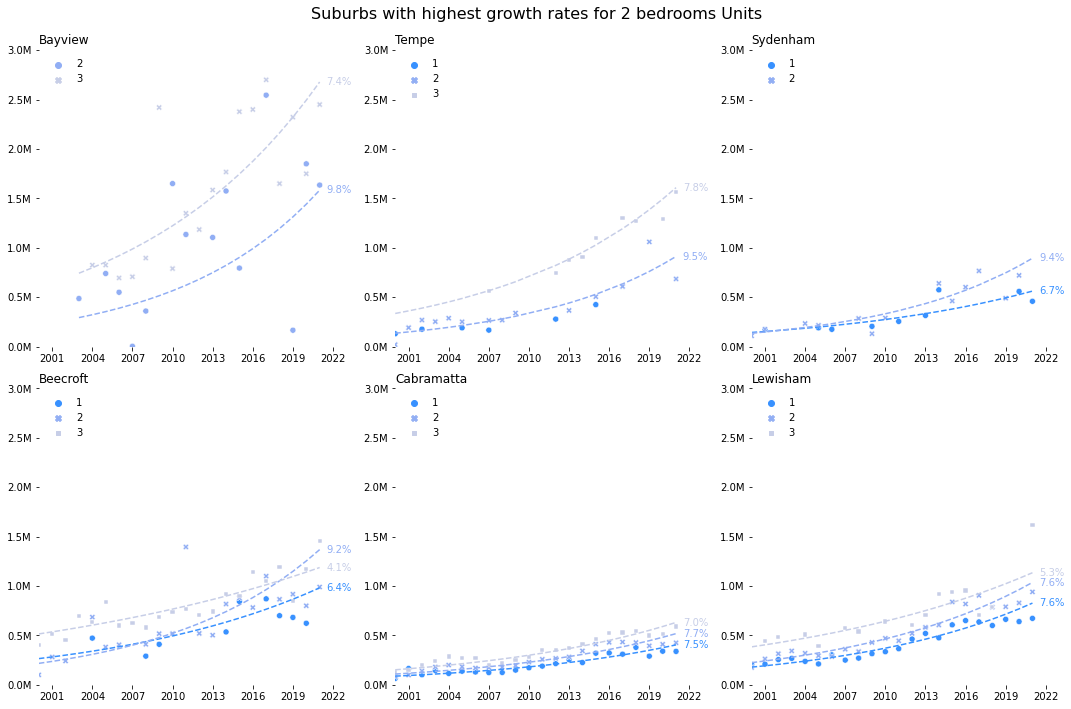

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = iter(axs.ravel())

top_loc_2bed = (
    df_unit_rates.query("bedrooms == 2")
    .sort_values("annual_rate", ascending=False)
    .locality.head(6)
)

df_plot = df_unit_sel.groupby(["locality", "bedrooms", "year"]).median().reset_index()
for loc in top_loc_2bed:
    ax = next(axs)
    plot_loc_trend_bed(df_plot, df_unit_rates, ax, loc)

fig.tight_layout()
fig.suptitle("Suburbs with highest growth rates for 2 bedrooms Units", size=16)
fig.subplots_adjust(top=0.92)


# Summary

This exploratory analysis reveals the general price trend of the property market in Sydney. Suburbs with different distance from CBD were also studied with comparisons of price trends in Houses and Units. Later section focused on Units of suburbs closed to the CBD for personal interest.

Moving forwards, more dataset (e.g. crime rate statistics, rail station proximity, etc.) could be introduced to enhance understanding of the profile of each suburb. 